# 1 - Imports

In [30]:
# native packages
import logging, warnings, time, itertools, random, os, json
from collections import deque, namedtuple
from typing import override

# some setup
warnings.filterwarnings('ignore', module='tqdm.auto')  # deprication warnings
warnings.filterwarnings('ignore', module='bettermdptools.RL')
logger = logging.getLogger(__name__)

# generic imports
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 14 # Set default font size to 14
import seaborn as sns
import pandas as pd

# RL libraries
import gymnasium as gym
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.utils.plots import Plots
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
from bettermdptools.envs import (
    blackjack_wrapper,
    cartpole_wrapper, 
    cartpole_model
)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## 2 - Utility Code

In [2]:
class RL_custom(RL):
    def __init__(self, name):
        super().__init__(name)

    @override
    def sarsa(
        self,
        nS=None,
        nA=None,
        convert_state_obs=lambda state: state,
        gamma=0.99,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.5,
        init_epsilon=1.0,
        min_epsilon=0.1,
        epsilon_decay_ratio=0.9,
        n_episodes=10000,
    ):
        """
        SARSA algorithm.

        Parameters
        ----------
        nS : int, optional
            Number of states, by default None.
        nA : int, optional
            Number of available actions, by default None.
        convert_state_obs : function, optional
            Converts state into an integer, by default lambda state: state.
        gamma : float, optional
            Discount factor, by default 0.99.
        init_alpha : float, optional
            Initial learning rate, by default 0.5.
        min_alpha : float, optional
            Minimum learning rate, by default 0.01.
        alpha_decay_ratio : float, optional
            Decay schedule of learning rate for future iterations, by default 0.5.
        init_epsilon : float, optional
            Initial epsilon value for epsilon greedy strategy, by default 1.0.
        min_epsilon : float, optional
            Minimum epsilon, by default 0.1.
        epsilon_decay_ratio : float, optional
            Decay schedule of epsilon for future iterations, by default 0.9.
        n_episodes : int, optional
            Number of episodes for the agent, by default 10000.

        Returns
        -------
        tuple
            Q : np.ndarray
                Final action-value function Q(s,a).
            V : np.ndarray
                State values array.
            pi : dict
                Policy mapping states to actions.
            Q_track : np.ndarray
                Log of Q(s,a) for each episode.
            pi_track : list
                Log of complete policy for each episode.
            rewards : np.ndarray
                Rewards obtained in each episode.
        """
        if nS is None:
            nS = self.env.observation_space.n
        if nA is None:
            nA = self.env.action_space.n
        pi_track = []
        Q = np.zeros((nS, nA), dtype=np.float32)
        Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float32)
        rewards = np.zeros(n_episodes, dtype=np.float32)
        times = np.zeros(n_episodes, dtype=np.float32)
        alphas = RL.decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
        epsilons = RL.decay_schedule(
            init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes
        )

        for e in tqdm(range(n_episodes), leave=False):
            self.callbacks.on_episode_begin(self)
            self.callbacks.on_episode(self, episode=e)
            state, info = self.env.reset()
            done = False
            start = time.time()
            state = convert_state_obs(state)
            action = self.select_action(state, Q, epsilons[e])
            total_reward = 0
            while not done:
                if self.render:
                    warnings.warn(
                        "Occasional render has been deprecated by openAI.  Use test_env.py to render."
                    )
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                if truncated:
                    warnings.warn(
                        "Episode was truncated.  TD target value may be incorrect."
                    )
                done = terminated or truncated
                self.callbacks.on_env_step(self)
                next_state = convert_state_obs(next_state)
                next_action = self.select_action(next_state, Q, epsilons[e])
                td_target = reward + gamma * Q[next_state][next_action] * (not done)
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error
                state, action = next_state, next_action
                total_reward += reward
            times[e] = time.time()-start
            rewards[e] = total_reward
            Q_track[e] = Q
            pi_track.append(np.argmax(Q, axis=1))
            self.render = False
            self.callbacks.on_episode_end(self)

        V = np.max(Q, axis=1)

        pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}
        output = {
            'Q': Q,
            'V': V,
            'pi': pi,
            'Q_track': Q_track,
            'pi_track': pi_track,
            'rewards': rewards,
            'times': times
        }
        return output


class Planner_custom(Planner):
    def __init__(self, name):
        super().__init__(name)

    @override
    def value_iteration(self, gamma=1.0, n_iters=1000, theta=1e-10, dtype=np.float32):
        """
        Value Iteration algorithm.

        Parameters
        ----------
        gamma : float, optional
            Discount factor, by default 1.0.
        n_iters : int, optional
            Number of iterations, by default 1000.
        theta : float, optional
            Convergence criterion for value iteration, by default 1e-10.

        Returns
        -------
        tuple
            V : np.ndarray
                State values array.
            V_track : np.ndarray
                Log of V(s) for each iteration.
            pi : dict
                Policy mapping states to actions.
        """
        V = np.zeros(len(self.P), dtype=dtype)
        V_track = np.zeros((n_iters, len(self.P)), dtype=dtype)
        times = np.zeros((n_iters, len(self.P)), dtype=dtype)
        converged = False
        for i in tqdm(range(n_iters), leave=False):
            start = time.time()
            Q = np.zeros((len(self.P), len(self.P[0])), dtype=dtype)
            for s in range(len(self.P)):
                for a in range(len(self.P[s])):
                    for prob, next_state, reward, done in self.P[s][a]:
                        Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
            times[i] = time.time()-start
            if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
                converged = True
            V = np.max(Q, axis=1)
            V_track[i] = V
            if converged:
                break
        if not converged:
            warnings.warn("Max iterations reached before convergence.  Check n_iters.")

        pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}
        output = {
            'V': V,
            'V_track': V_track,
            'pi': pi,
            'times': times
        }
        return output
    
    @override
    def policy_iteration(self, gamma=1.0, n_iters=50, theta=1e-10, dtype=np.float32):
        """
        Policy Iteration algorithm.

        Parameters
        ----------
        gamma : float, optional
            Discount factor, by default 1.0.
        n_iters : int, optional
            Number of iterations, by default 50.
        theta : float, optional
            Convergence criterion for policy evaluation, by default 1e-10.

        Returns
        -------
        tuple
            V : np.ndarray
                State values array.
            V_track : np.ndarray
                Log of V(s) for each iteration.
            pi : dict
                Policy mapping states to actions.
        """
        random_actions = np.random.choice(tuple(self.P[0].keys()), len(self.P))

        pi = {s: a for s, a in enumerate(random_actions)}
        # initial V to give to `policy_evaluation` for the first time
        V = np.zeros(len(self.P), dtype=dtype)
        V_track = np.zeros((n_iters, len(self.P)), dtype=dtype)
        times = np.zeros((n_iters, len(self.P)), dtype=dtype)
        converged = False
        for i in tqdm(range(n_iters), leave=False):
            start = time.time()
            old_pi = pi
            V = self.policy_evaluation(pi, V, gamma=gamma, theta=theta, dtype=dtype)
            V_track[i] = V
            pi = self.policy_improvement(V, gamma=gamma, dtype=dtype)
            times[i] = time.time()-start
            if old_pi == pi:
                converged = True
                break
        if not converged:
            warnings.warn("Max iterations reached before convergence.  Check n_iters.")
        output = {
            'V': V,
            'V_track': V_track,
            'pi': pi,
            'times': times
        }
        return output

def plot_track(results, track_name, envname=''):
    if track_name=='Q_track':
        track = np.reshape(results[track_name], (results[track_name].shape[0],-1))
    else:
        track = results[track_name]
    if track.shape[1] > 15000:
        track = track[:,:15000]
    track = np.array([track[i] for i in range(track.shape[0]) if sum(track[i])!=0 or i==0]) # trim tailing states
    deltas = np.array([track[i+1]-track[i] for i in range(track.shape[0]-1)])
    sum_abs_deltas = np.array([np.sum(np.abs(d)) for d in deltas])
    max_abs_deltas = np.array([np.max(d) for d in deltas])

    # show V
    for i in tqdm(range(track.shape[1]), leave=False):
        plt.plot(track[:, i], alpha=0.5)
    plt.xlabel('Iterations')
    plt.ylabel('State Values')
    plt.title(f'{envname} {track_name} by Iteration')
    plt.show()

    # show d V
    for i in tqdm(range(deltas.shape[1]), leave=False):
        plt.plot(deltas[:, i], alpha=0.5)
    plt.xlabel('Iterations')
    plt.ylabel('State Value Deltas')
    plt.title(f'{envname} {track_name} Deltas by Iteration')
    plt.show()

    plt.plot(sum_abs_deltas)
    plt.xlabel('Iterations')
    plt.ylabel('Absolute Sum Value Deltas')
    plt.title(f'{envname} Absolute Sum {track_name} Deltas Over Iterations')
    plt.show()

    plt.plot(max_abs_deltas)
    plt.xlabel('Iterations')
    plt.ylabel('Absolute Max Value Delta')
    plt.title(f'{envname} Max Absolute {track_name} Over Iterations')
    plt.show()

def plot_rewards(rewards):
    plt.scatter(range(len(rewards)), rewards, alpha=0.5, label='Reward')
    plt.plot([np.mean(rewards[:i]) for i in range(1, len(rewards))], label='Average Reward', color='orange')
    plt.title('Rewards by Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Rewards')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot([np.sum(rewards[:i]) for i in range(1, len(rewards))])
    plt.xlabel('Iterations')
    plt.ylabel('Sum of Rewards')
    plt.title('Cumulative Rewards by Iteration')
    plt.show

def save_experiment_results(filename, algorithm, index, times, scores, pb, vb, avb, tb, acr, aor):
    try:
        iter(times[0])
        iterable=True
    except:
        iterable=False
    if iterable:
        times = list(list([float(t) for t in ep]) for ep in times)
    else:
        times = [float(t) for t in times]
    results = {
        'position_bins': int(pb),
        'velocity_bins': int(vb),
        'angular_velocity_bins': int(avb),
        'threshold_bins': float(tb),
        'angular_center_resolution': float(acr),
        'angular_outer_resolution': float(aor),
        'times': times,
        'scores': list(scores),
        'index': index,
        'algorithm': algorithm
    }
    with open(f'./logs/{filename}.json', 'w+') as file:
        json.dump(results, file)

def plot_blackjack_policy(results, lookup, algo=None):
    pi = results['pi']
    sticks = []
    hits = []
    for state_index in tqdm(lookup.keys()):
        action = pi[state_index]
        if action==0:
            sticks.append(lookup[state_index])
        else:
            hits.append(lookup[state_index])
    plt.scatter([x[0] for x in sticks], [x[1] for x in sticks], c='blue', label='stick', alpha=0.5)
    plt.scatter([x[0] for x in hits], [x[1] for x in hits], c='orange', label='hit', alpha=0.5)
    plt.xlabel('Current Player Score')
    plt.ylabel('Revealed Dealer Card')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'{algo} Blackjack Policy')
    plt.show()

def plot_cartpole_policy(results, lookup, algo=None):
    obs_features = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
    fig, ax = plt.subplots(nrows=2, ncols=2)
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            if i==1 and j==0:
                k = 2
            elif i==j==1:
                k = 3
            else:
                k = i+j
            X = [key for key in lookup.keys() if results['pi'][int(key)]==0]
            y = [lookup[key][k] for key in X]
            col.scatter([int(x) for x in X], y, s=0.25)
            ax[i,j].set_title(obs_features[k])
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.suptitle(f'{algo} Observations Where Policy Moves Left')
    plt.show()

    obs_features = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
    fig, ax = plt.subplots(nrows=2, ncols=2)
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            if i==1 and j==0:
                k = 2
            elif i==j==1:
                k = 3
            else:
                k = i+j
            X = [key for key in lookup.keys() if results['pi'][int(key)]==1]
            y = [lookup[key][k] for key in X]
            col.scatter([int(x) for x in X], y, s=0.25)
            ax[i,j].set_title(obs_features[k])
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.suptitle(f'{algo} Observations Where Policy Moves Right')
    plt.show()

# 3 - Blackjack

In [3]:
# blackjack gym environment
blackjack_env = gym.make('Blackjack-v1')
blackjack = RL_custom(blackjack_wrapper.BlackjackWrapper(blackjack_env))

if not os.path.exists('./blackjack_state.json'):
    blackjack_state_lookup = {}
    blackjack_transform = lambda obs: (
        int(f"{28}{(obs[1] - 2) % 10}")
        if (obs[0] == 21 and obs[2])
        else int(f"{27}{(obs[1] - 2) % 10}")
        if (obs[0] == 21 and not obs[2])
        else int(f"{obs[0] + 6}{(obs[1] - 2) % 10}")
        if obs[2]
        else int(f"{obs[0] - 4}{(obs[1] - 2) % 10}")
    )
    for i, j, k in itertools.product(range(4,22), range(1,11), range(2)):
        blackjack_state_lookup.update({blackjack_transform((i,j,k)): (i,j,k)})
    with open('./blackjack_states.json', 'w+') as file:
        json.dump(blackjack_state_lookup, file)
else:
    with open('./blackjack_states.json', 'r') as file:
        blackjack_state_lookup = json.load(file)

## 3.1 - VI & PI

[ 1.  1.  1.  1.  1. -1. -1. -1.  1.  0.]


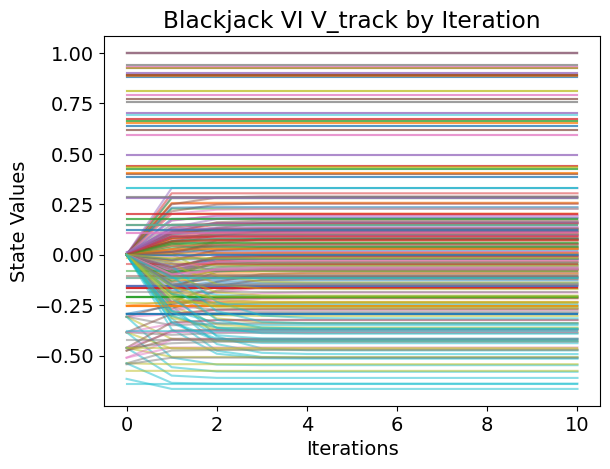

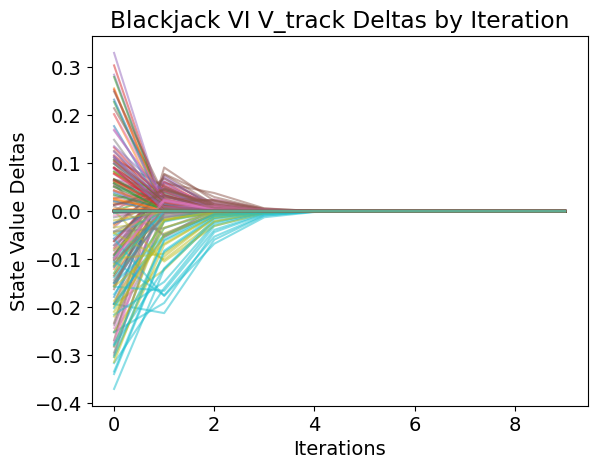

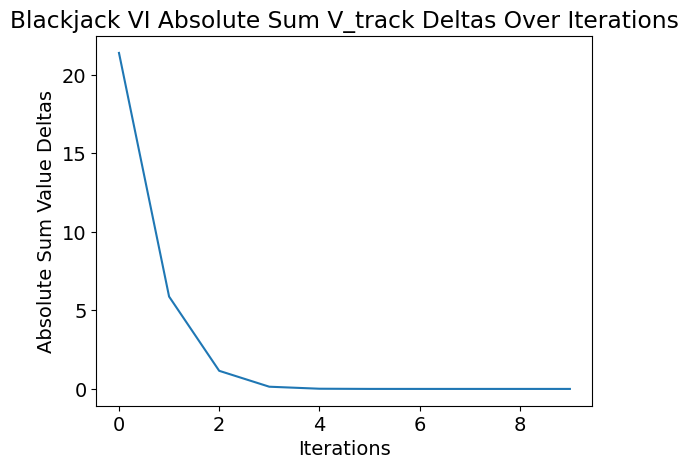

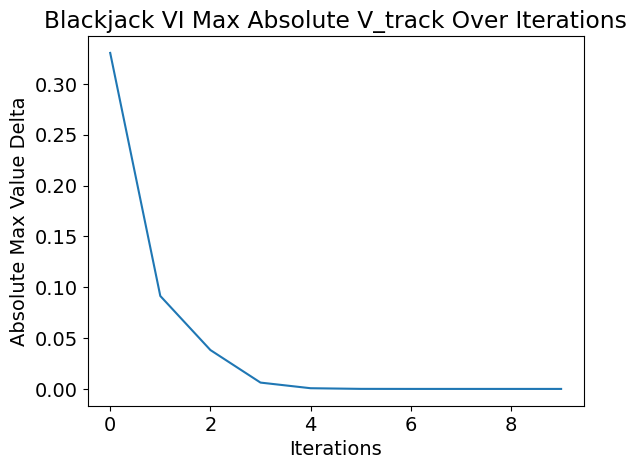

100%|██████████| 290/290 [00:00<00:00, 340047.01it/s]


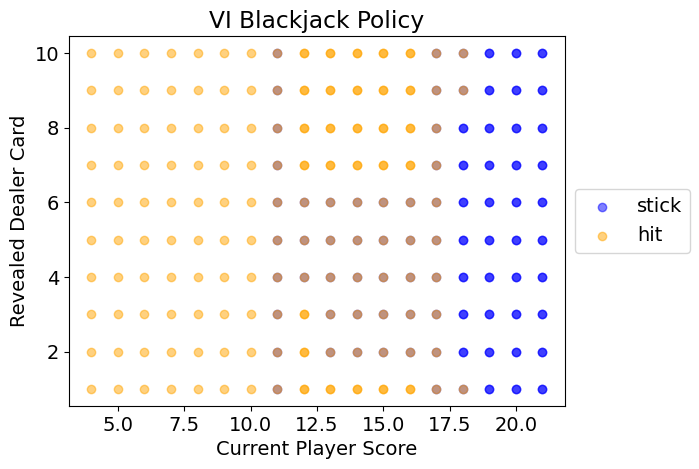

[ 1. -1. -1. -1.  1. -1. -1.  1.  1.  1.]


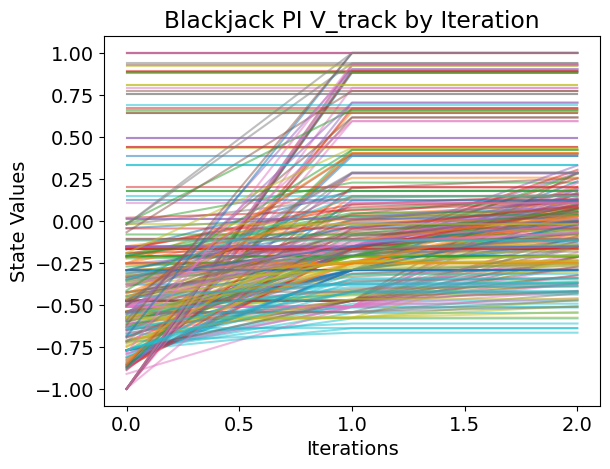

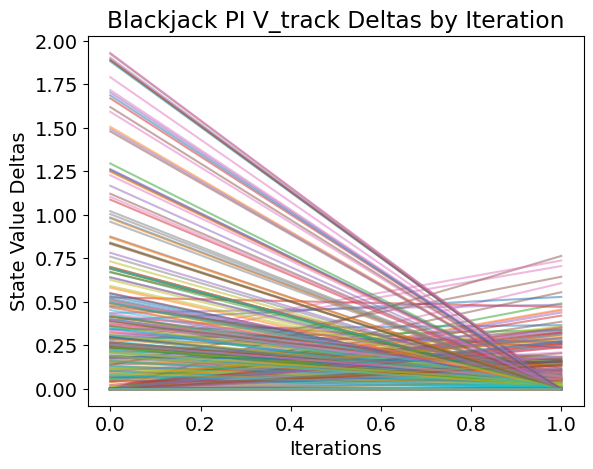

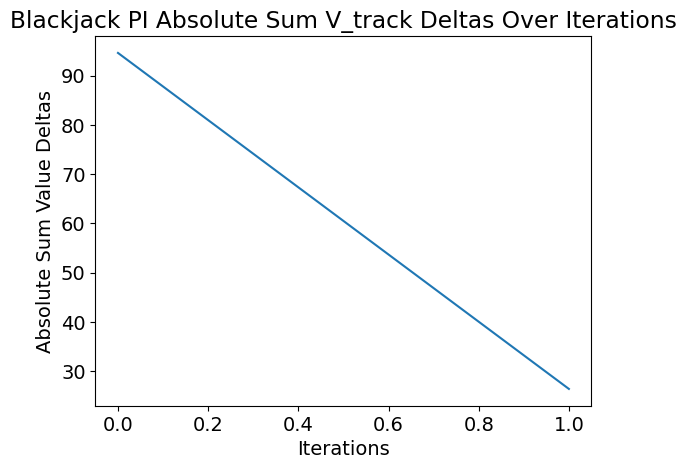

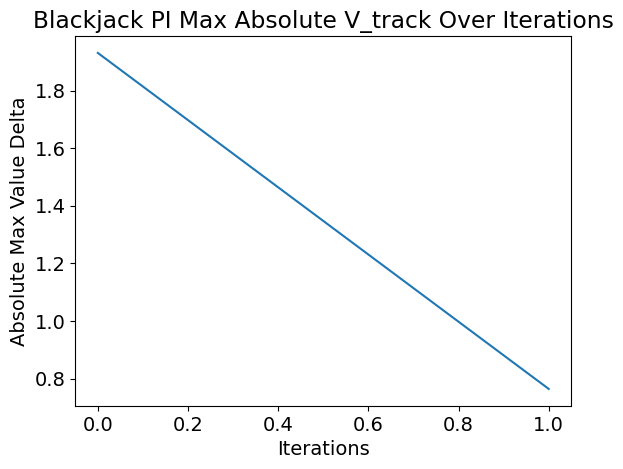

100%|██████████| 290/290 [00:00<00:00, 148516.26it/s]


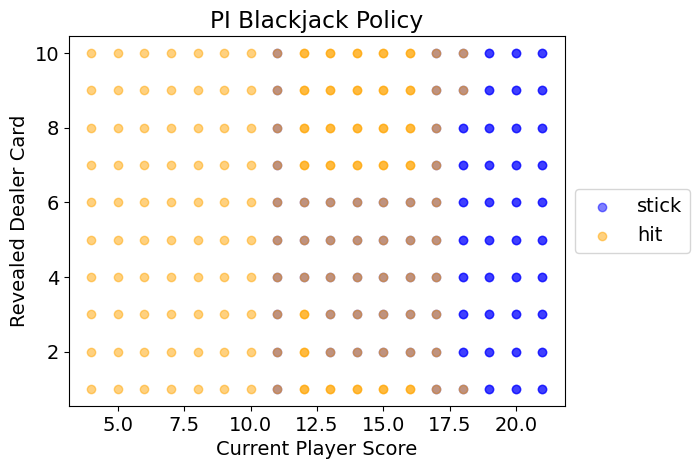

In [4]:
# run VI
blackjack.env.reset()
blackjack_vi_results = Planner_custom(blackjack.env.P).value_iteration(gamma=0.99)
print(TestEnv().test_env(blackjack.env, pi=blackjack_vi_results['pi']))
plot_track(blackjack_vi_results, 'V_track', envname='Blackjack VI')
plot_blackjack_policy(blackjack_vi_results, blackjack_state_lookup, 'VI')

blackjack.env.reset()
blackjack_pi_results = Planner_custom(blackjack.env.P).policy_iteration(gamma=0.99)
print(TestEnv().test_env(blackjack.env, pi=blackjack_pi_results['pi']))
plot_track(blackjack_pi_results, 'V_track', envname='Blackjack PI')
plot_blackjack_policy(blackjack_pi_results, blackjack_state_lookup, 'PI')

In [5]:
print(sum([sum(epoch) for epoch in blackjack_vi_results['times'][:11]]))
print(sum([sum(epoch) for epoch in blackjack_pi_results['times'][:4]]))

28.743814
32.267815


## 3.2 - SARSA

  0%|          | 0/10000 [00:00<?, ?it/s]

[ 1.  1.  1.  0.  0. -1. -1. -1.  1.  1.]


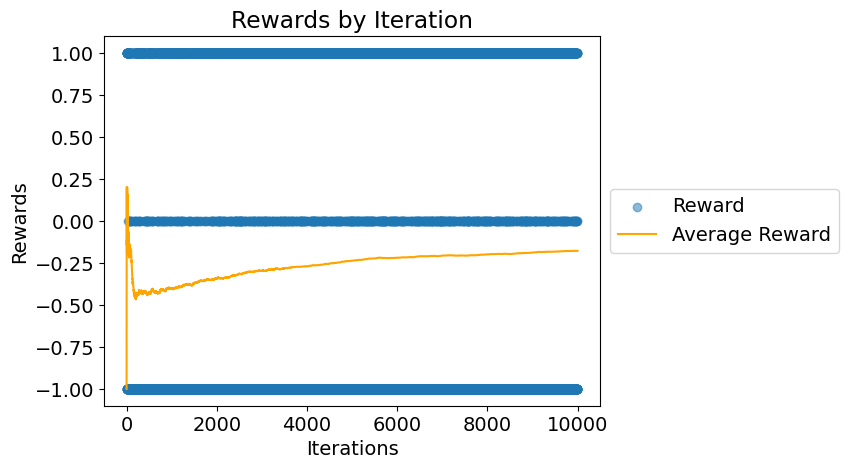

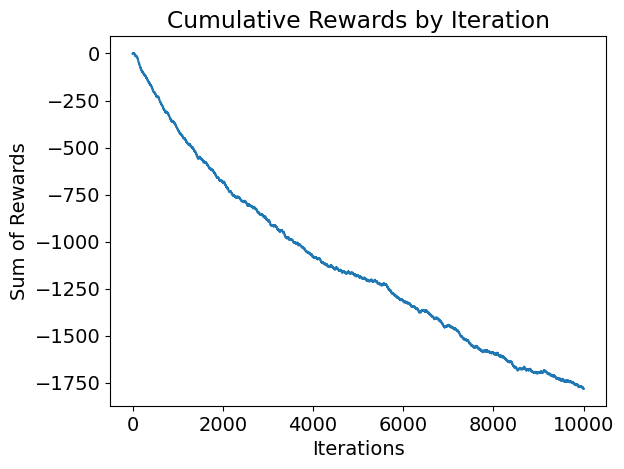

In [6]:
blackjack_sarsa_results = blackjack.sarsa()
print(TestEnv().test_env(blackjack.env, pi=blackjack_sarsa_results['pi']))
plot_rewards(blackjack_sarsa_results['rewards'])

100%|██████████| 290/290 [00:00<?, ?it/s]


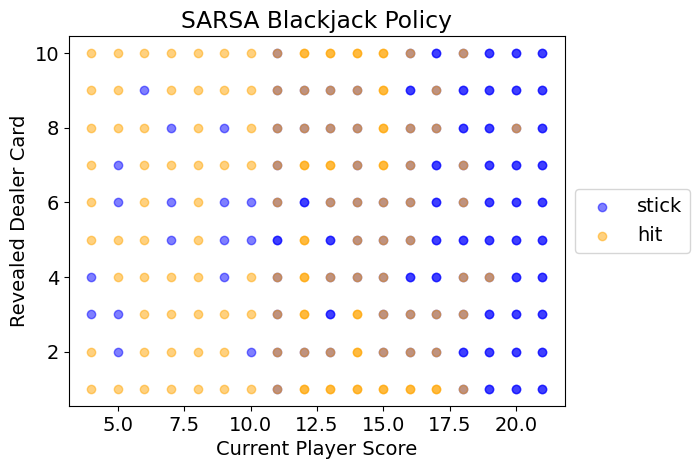

In [7]:
plot_blackjack_policy(blackjack_sarsa_results, blackjack_state_lookup, 'SARSA')

In [8]:
np.sum(blackjack_sarsa_results['times'])

np.float32(1.9892957)

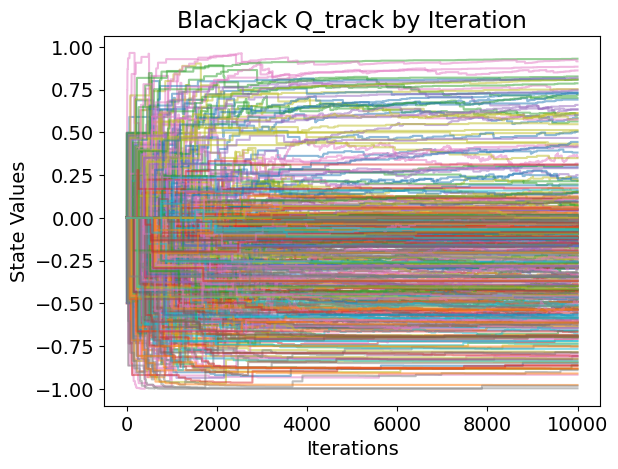

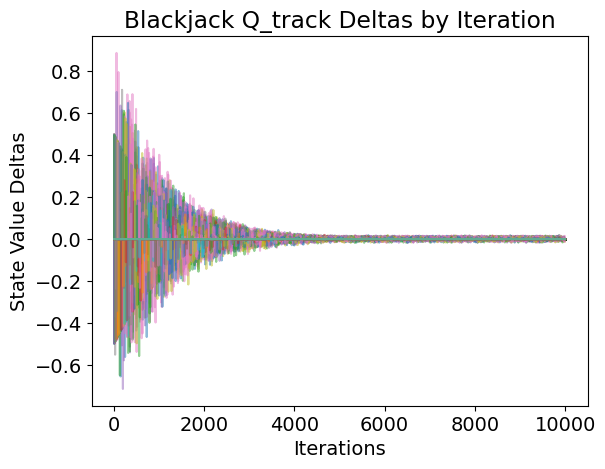

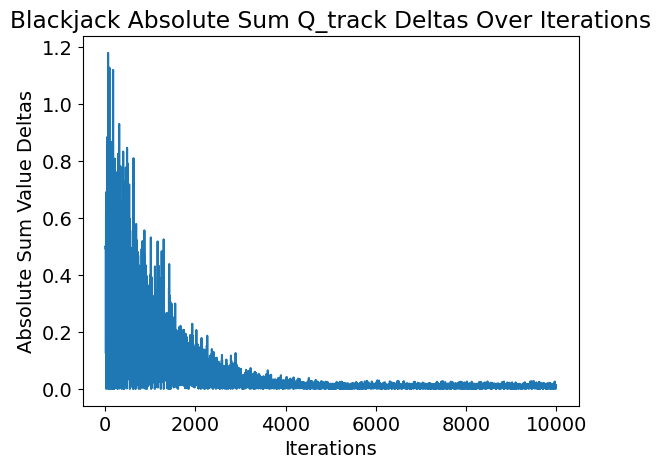

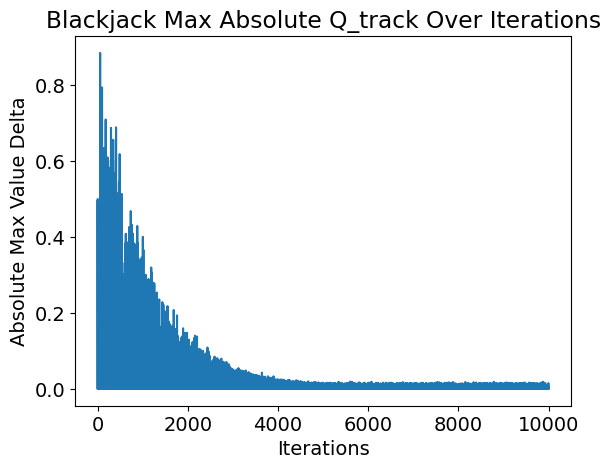

In [9]:
plot_track(blackjack_sarsa_results, 'Q_track', envname='Blackjack')

100%|██████████| 64/64 [00:32<00:00,  1.98it/s]


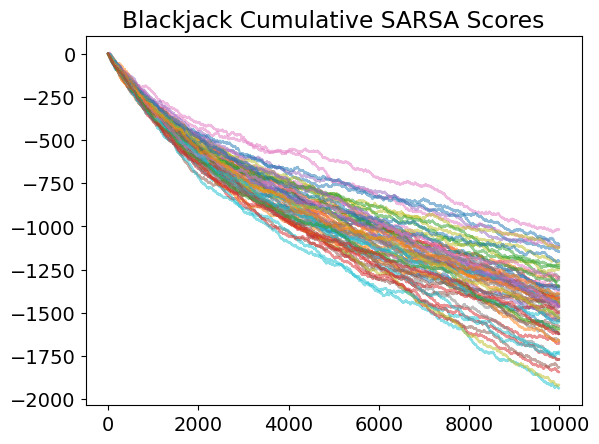

Best Result
params
(0.99, 0.5, 0.01, 0.7, 0, 0.5)
score
-1016.0


In [10]:
if not os.path.exists('./blackjack_sarsa/'):
    os.mkdir('./blackjack_sarsa')

sarsa_params = {
    'gamma': [0.9, 0.99],
    'init_alpha': [0.5, 0.7],
    'min_alpha': [0.01, 0.1],
    'alpha_decay_ratio': [0.5, 0.7],
    'min_epsilon': [0, 0.1],
    'epsilon_decay_ratio': [0.5, 0.9]
}
sarsa_params = list(itertools.product(*[sarsa_params[key] for key in sarsa_params.keys()]))
end_scores = []
for i, (g, ia, ma, adr, me, edr) in tqdm(enumerate(sarsa_params), total=len(sarsa_params)):
    if not os.path.exists(f'./blackjack_sarsa/{i}.json'):
        blackjack.env.reset()
        sarsa_scores = blackjack.sarsa(
            gamma=g,
            init_alpha=ia,
            min_alpha=ma,
            alpha_decay_ratio=adr,
            min_epsilon=me,
            epsilon_decay_ratio=edr
        )['rewards']
        results = {
            'gamma': g,
            'init_alpha': ia,
            'min_alpha': ma,
            'alpha_decay_ratio': adr,
            'min_epsilon': me,
            'epsilon_decay_ratio': edr,
            'scores': [float(x) for x in sarsa_scores],
            'index': i
        }
        with open(f'./blackjack_sarsa/{i}.json', 'w+') as file:
            json.dump(results, file)
    else:
        with open(f'./blackjack_sarsa/{i}.json', 'r') as file:
            results = json.load(file)
    cumulative_scores = [sum(results['scores'][:i+1]) for i in range(len(results['scores']))]
    end_scores.append(cumulative_scores[-1])
    plt.plot(
        cumulative_scores,
        label=f'{i}: {cumulative_scores[-1]}',
        alpha=0.5
    )
plt.title('Blackjack Cumulative SARSA Scores')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=4)
plt.show()

print('Best Result')
best_idx = np.argmax(end_scores)
print('params')
print(sarsa_params[best_idx])
print('score')
print(end_scores[best_idx])


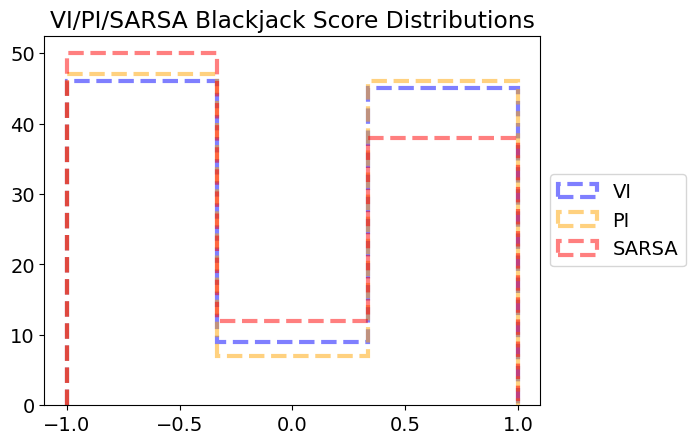

-1.0 -1.0 -12.0


In [11]:
VI_scores = TestEnv().test_env(blackjack.env, pi=blackjack_vi_results['pi'], n_iters=100)
plt.hist(VI_scores, label='VI', color='blue', histtype='step', bins=3, alpha=0.5, linewidth=3, linestyle='dashed')
PI_scores = TestEnv().test_env(blackjack.env, pi=blackjack_pi_results['pi'], n_iters=100)
plt.hist(PI_scores, label='PI', color='orange', histtype='step', bins=3, alpha=0.5, linewidth=3, linestyle='dashed')
SARSA_scores = TestEnv().test_env(blackjack.env, pi=blackjack_sarsa_results['pi'], n_iters=100)
plt.hist(SARSA_scores, label='SARSA', color='red', histtype='step', bins=3, alpha=0.5, linewidth=3, linestyle='dashed')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('VI/PI/SARSA Blackjack Score Distributions')
plt.show()
print(sum(VI_scores), sum(PI_scores), sum(SARSA_scores))

# 4 - CartPole

In [12]:
# cartpole gym environemnt
cartpole_env = gym.make('CartPole-v1')
cartpole = RL_custom(cartpole_wrapper.CartpoleWrapper(
    cartpole_env,
    position_bins=10,
    velocity_bins=10,
    angular_velocity_bins=10, 
    threshold_bins=0.1,
    angular_center_resolution=0.1,
    angular_outer_resolution=0.5
))

if not os.path.exists('./cartpole_states.json'):
    discrete = cartpole_wrapper.DiscretizedCartPole(
        position_bins=10,
        velocity_bins=10,
        angular_velocity_bins=10, 
        threshold_bins=0.1,
        angular_center_resolution=0.1,
        angular_outer_resolution=0.5)
    cartpole_state_lookup = {}
    cartpole_transform = lambda obs: (
        np.ravel_multi_index(
            (
                np.clip(
                    np.digitize(
                        obs[0],
                        np.linspace(*discrete.position_range, discrete.position_bins),
                    )
                    - 1,
                    0,
                    discrete.position_bins - 1,
                ),
                np.clip(
                    np.digitize(
                        obs[1],
                        np.linspace(*discrete.velocity_range, discrete.velocity_bins),
                    )
                    - 1,
                    0,
                    discrete.velocity_bins - 1,
                ),
                np.clip(
                    np.digitize(obs[2], discrete.angle_bins) - 1,
                    0,
                    len(discrete.angle_bins) - 1,
                ),
                # Use adaptive angle bins
                np.clip(
                    np.digitize(
                        obs[3],
                        np.linspace(
                            *discrete.angular_velocity_range, discrete.angular_velocity_bins
                        ),
                    )
                    - 1,
                    0,
                    discrete.angular_velocity_bins - 1,
                ),
            ),
            (
                discrete.position_bins,
                discrete.velocity_bins,
                len(discrete.angle_bins),
                discrete.angular_velocity_bins,
            ),
        )
    )
    for i,j,k,l in itertools.product(
        np.linspace(*discrete.position_range, discrete.position_bins), 
        np.linspace(*discrete.velocity_range, discrete.velocity_bins), 
        discrete.angle_bins, 
        np.linspace(*discrete.angular_velocity_range, discrete.angular_velocity_bins)
        ):
        cartpole_state_lookup.update({int(cartpole_transform((i,j,k,l))): [float(x) for x in (i,j,k,l)]})
    with open('./cartpole_states.json', 'w+') as file:
        json.dump(cartpole_state_lookup, file)
else:
    with open('./cartpole_states.json', 'r') as file:
        cartpole_state_lookup = json.load(file)

## 4.1 - VI & PI

[252. 269. 268. 254. 250. 249. 268. 269. 277. 250.]


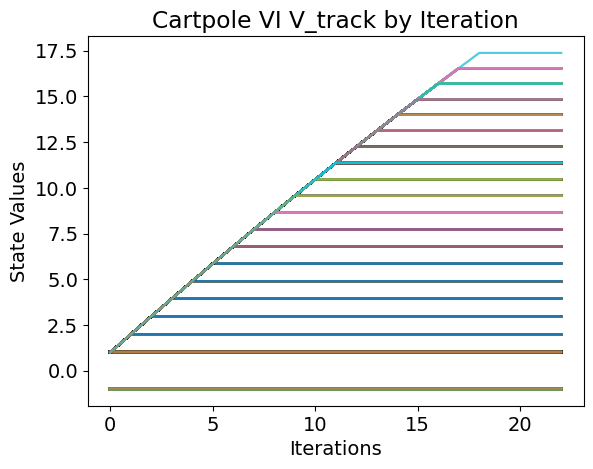

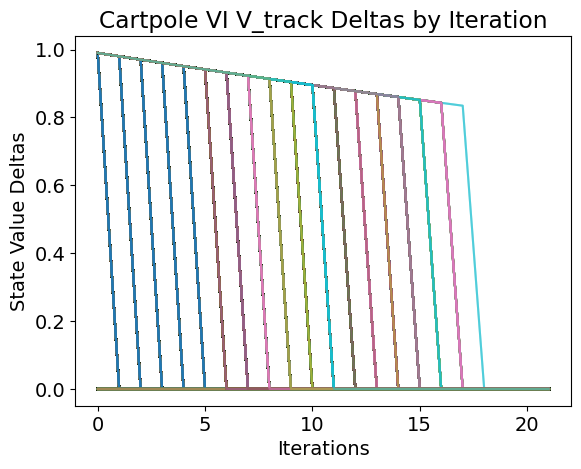

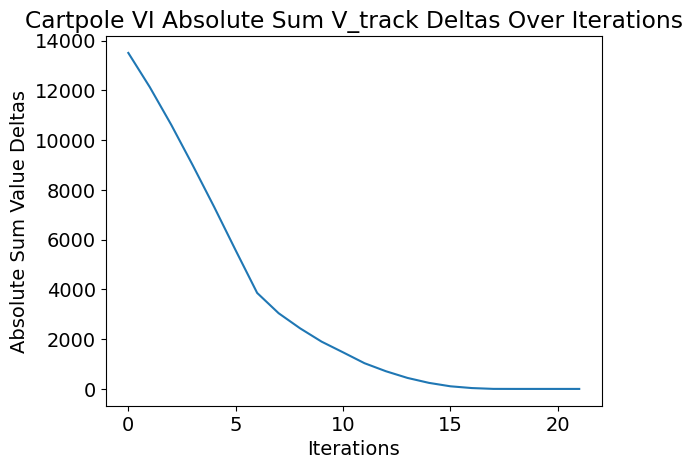

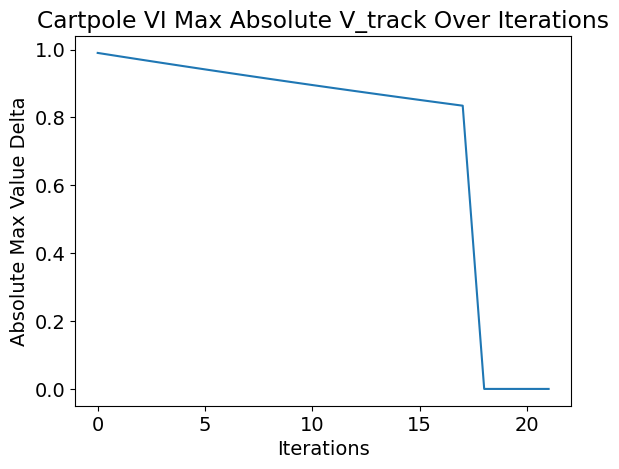

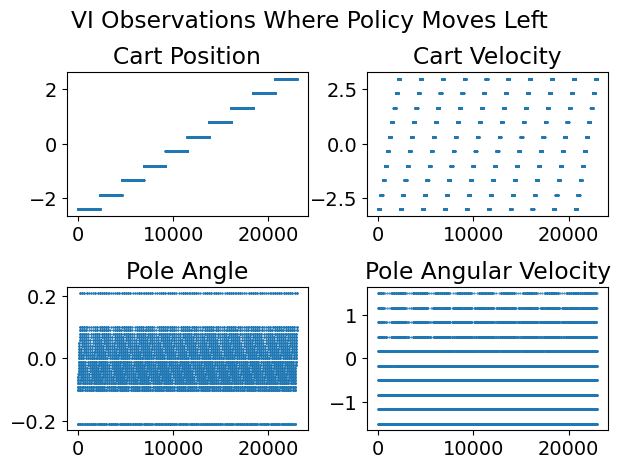

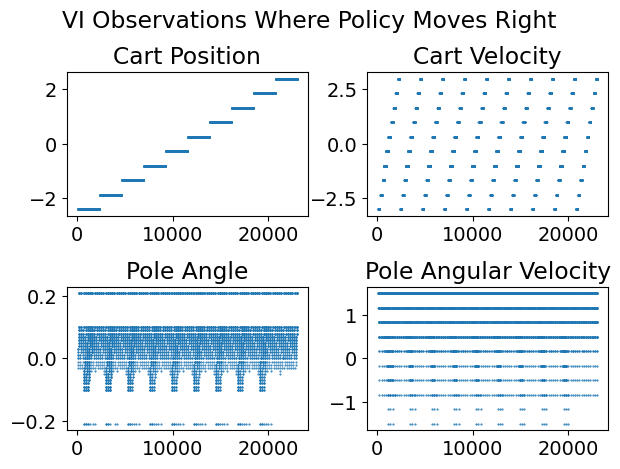

[244. 273. 242. 238. 245. 230. 232. 215. 242. 241.]


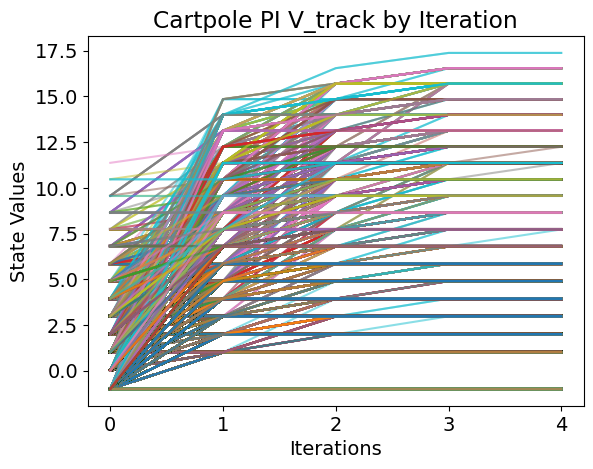

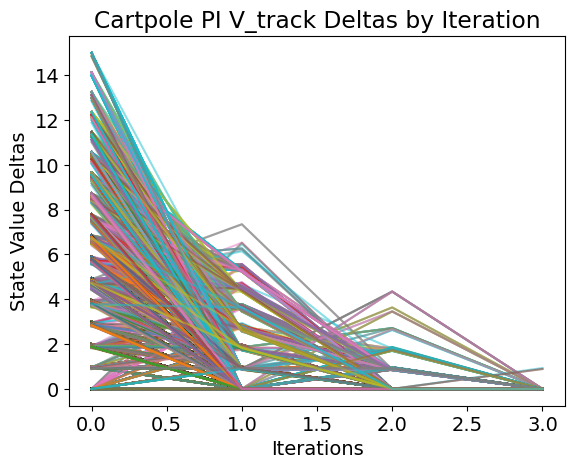

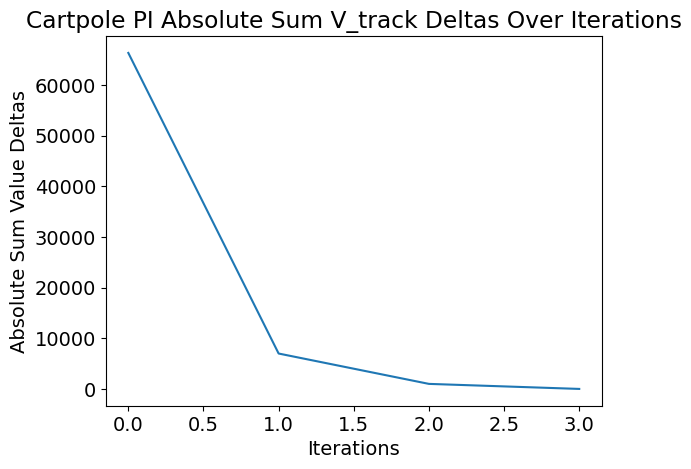

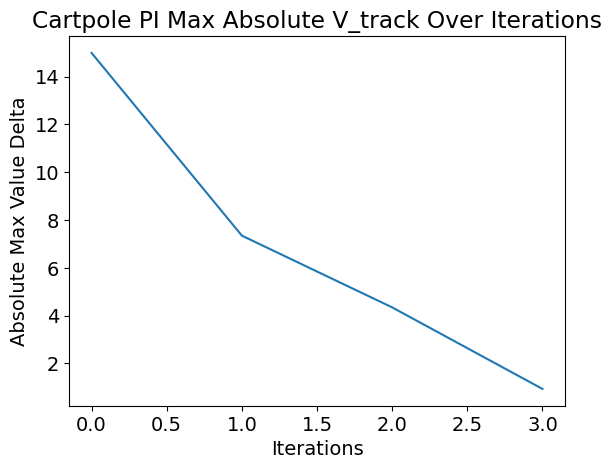

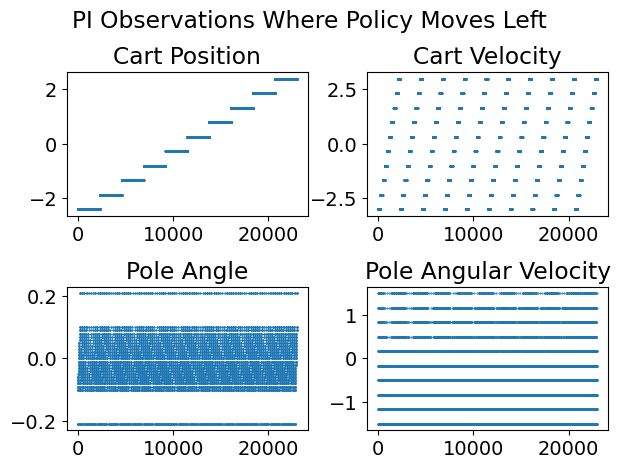

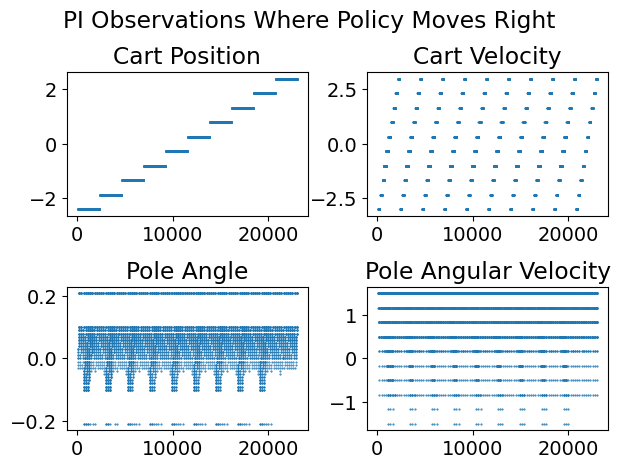

In [13]:
# run VI
cartpole.env.reset()
cartpole_vi_results = Planner_custom(cartpole.env.P).value_iteration(gamma=0.99)
print(TestEnv().test_env(cartpole.env, pi=cartpole_vi_results['pi']))
plot_track(cartpole_vi_results, 'V_track', envname='Cartpole VI')
plot_cartpole_policy(cartpole_vi_results, cartpole_state_lookup, algo='VI')

# run PI
cartpole.env.reset()
cartpole_pi_results = Planner_custom(cartpole.env.P).policy_iteration(gamma=0.99)
print(TestEnv().test_env(cartpole.env, pi=cartpole_pi_results['pi']))
plot_track(cartpole_pi_results, 'V_track', envname='Cartpole PI')
plot_cartpole_policy(cartpole_vi_results, cartpole_state_lookup, algo='PI')

In [14]:
print(sum([sum(epoch) for epoch in cartpole_vi_results['times'][:23]]))
print(sum([sum(epoch) for epoch in cartpole_pi_results['times'][:5]]))

30903.127
41644.918


In [15]:
VI_n_left = len([key for key in cartpole_vi_results['pi'].keys() if cartpole_vi_results['pi'][key]==0])
print(VI_n_left)
print(VI_n_left/23000)

PI_n_left = len([key for key in cartpole_pi_results['pi'].keys() if cartpole_pi_results['pi'][key]==0])
print(PI_n_left)
print(PI_n_left/23000)

16870
0.7334782608695652
16870
0.7334782608695652


## 4.2 - SARSA

In [16]:
cartpole_sarsa_results = cartpole.sarsa()
print(TestEnv().test_env(cartpole.env, pi=cartpole_sarsa_results['pi']))

 30%|██▉       | 2968/10000 [00:35<02:57, 39.56it/s] C:\Users\kaleb\AppData\Local\Temp\ipykernel_17152\2875530256.py:94: UserWarning: Episode was truncated.  TD target value may be incorrect.
  warnings.warn(


[273. 181. 157. 256. 195. 169. 103. 155. 105. 137.]


In [17]:
# print(cartpole_vi_results['pi'] == cartpole_pi_results['pi'])
# print(cartpole_vi_results['pi'] == cartpole_sarsa_results['pi'])

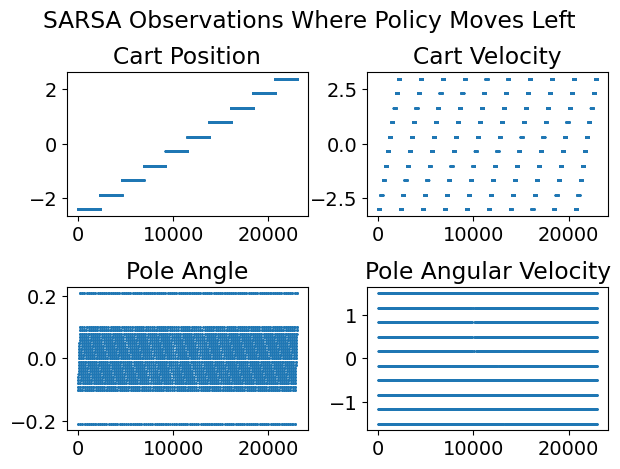

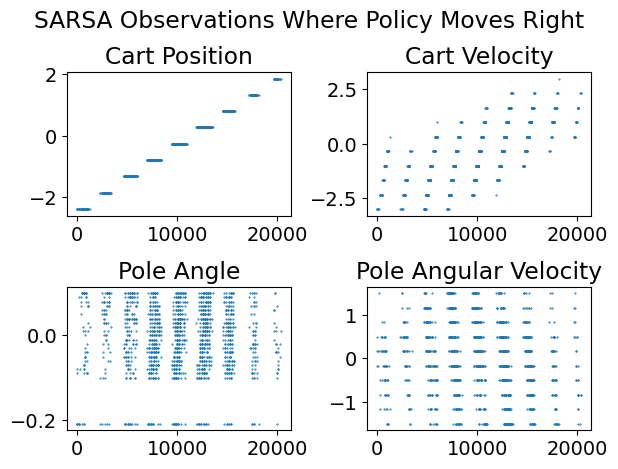

In [18]:
plot_cartpole_policy(cartpole_sarsa_results, cartpole_state_lookup, algo='SARSA')

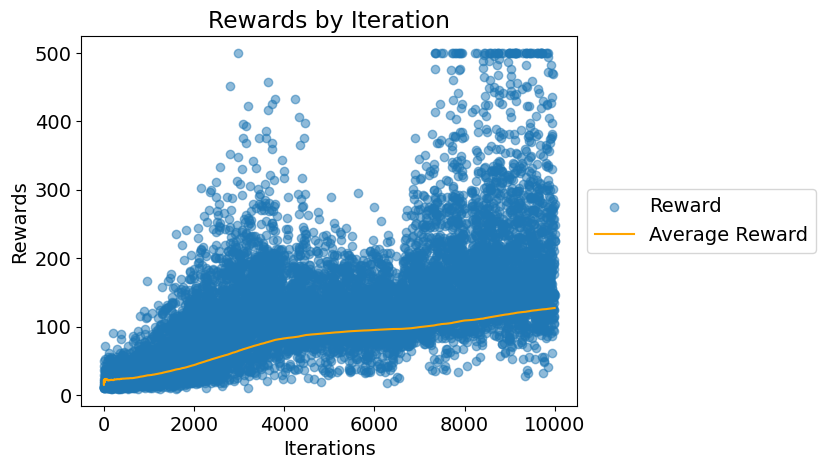

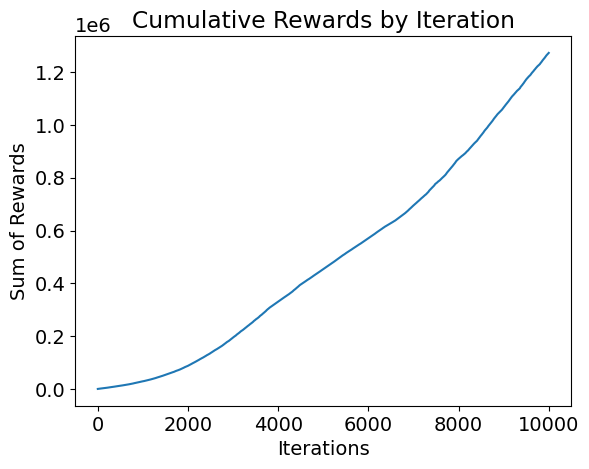

In [19]:
plot_rewards(cartpole_sarsa_results['rewards'])

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:37<00:00,  1.71it/s]


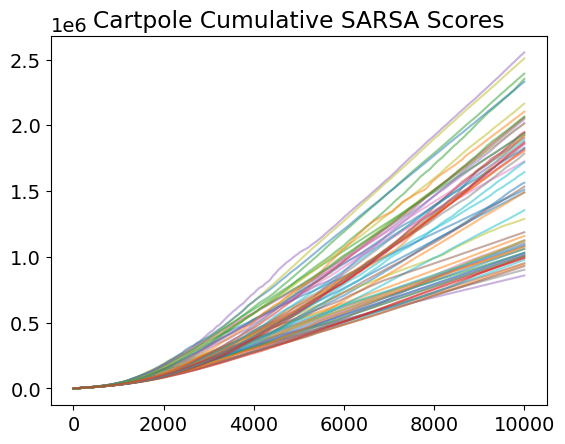

Best Result
params
(0.99, 0.5, 0.1, 0.7, 0, 0.5)
score
2553475.0


In [20]:
if not os.path.exists('./cartpole_sarsa/'):
    os.mkdir('./cartpole_sarsa')

sarsa_params = {
    'gamma': [0.9, 0.99],
    'init_alpha': [0.5, 0.7],
    'min_alpha': [0.01, 0.1],
    'alpha_decay_ratio': [0.5, 0.7],
    'min_epsilon': [0, 0.1],
    'epsilon_decay_ratio': [0.5, 0.9]
}
end_scores = []
sarsa_params = list(itertools.product(*[sarsa_params[key] for key in sarsa_params.keys()]))
for i, (g, ia, ma, adr, me, edr) in tqdm(enumerate(sarsa_params), total=len(sarsa_params)):
    if not os.path.exists(f'./cartpole_sarsa/{i}.json'):
        cartpole.env.reset()
        sarsa_scores = cartpole.sarsa(
            gamma=g,
            init_alpha=ia,
            min_alpha=ma,
            alpha_decay_ratio=adr,
            min_epsilon=me,
            epsilon_decay_ratio=edr
        )['rewards']
        results = {
            'gamma': g,
            'init_alpha': ia,
            'min_alpha': ma,
            'alpha_decay_ratio': adr,
            'min_epsilon': me,
            'epsilon_decay_ratio': edr,
            'scores': [float(x) for x in sarsa_scores],
            'index': i
        }
        with open(f'./cartpole_sarsa/{i}.json', 'w+') as file:
            json.dump(results, file)
    else:
        with open(f'./cartpole_sarsa/{i}.json', 'r') as file:
            results = json.load(file)
    cumulative_scores = [sum(results['scores'][:i+1]) for i in range(len(results['scores']))]
    end_scores.append(cumulative_scores[-1])
    plt.plot(
        cumulative_scores,
        label=f'{i}: {cumulative_scores[-1]}',
        alpha=0.5
    )
plt.title('Cartpole Cumulative SARSA Scores')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=4)
plt.show()

print('Best Result')
best_idx = np.argmax(end_scores)
print('params')
print(sarsa_params[best_idx])
print('score')
print(end_scores[best_idx])

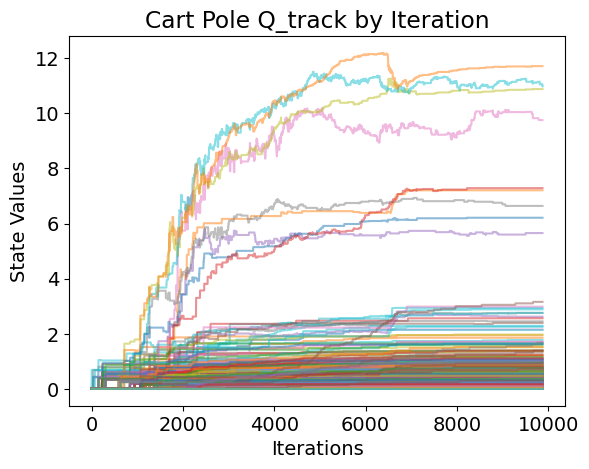

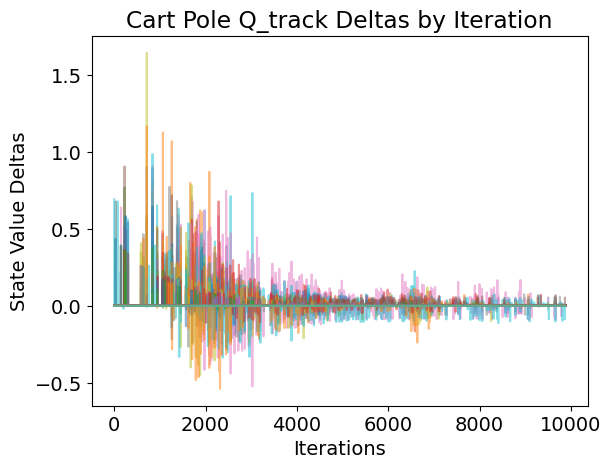

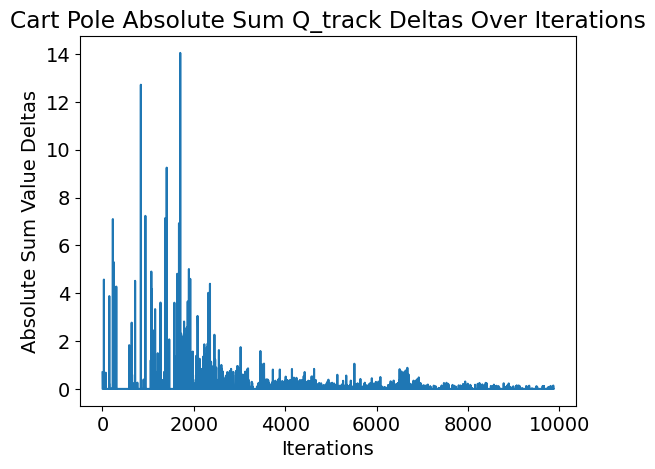

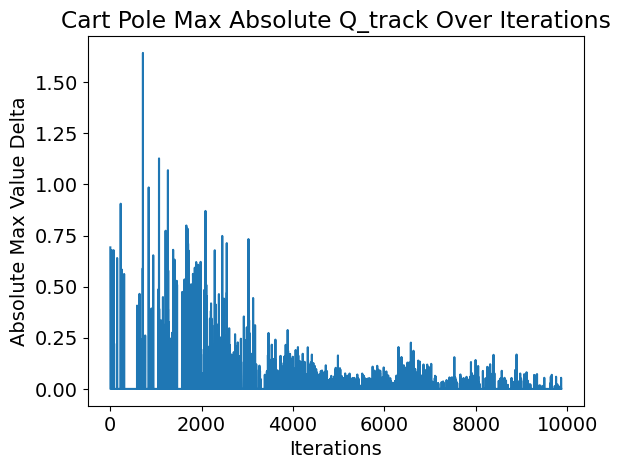

In [21]:
plot_track(cartpole_sarsa_results, 'Q_track', envname='Cart Pole')

In [22]:
np.sum(cartpole_sarsa_results['times'])

np.float32(273.02783)

In [23]:
pd.Series(cartpole_sarsa_results['pi'].values()).value_counts()

0    21540
1     1460
Name: count, dtype: int64

In [24]:
21469/23000

0.9334347826086956

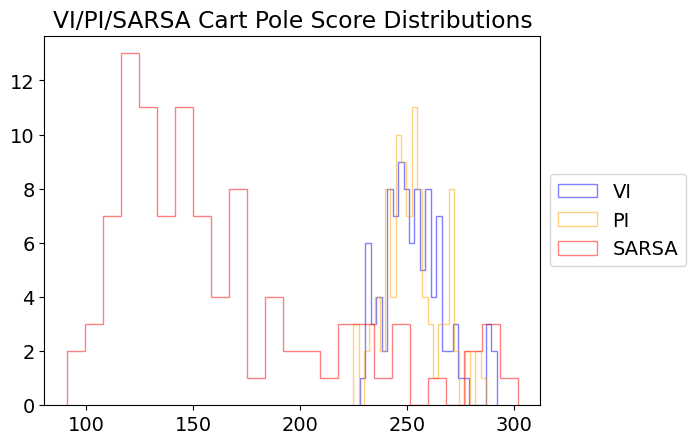

25337.0 25260.0 16208.0


In [25]:
VI_scores = TestEnv().test_env(cartpole.env, pi=cartpole_vi_results['pi'], n_iters=100)
plt.hist(VI_scores, label='VI', color='blue', histtype='step', bins=25, alpha=0.5)
PI_scores = TestEnv().test_env(cartpole.env, pi=cartpole_pi_results['pi'], n_iters=100)
plt.hist(PI_scores, label='PI', color='orange', histtype='step', bins=25, alpha=0.5)
SARSA_scores = TestEnv().test_env(cartpole.env, pi=cartpole_sarsa_results['pi'], n_iters=100)
plt.hist(SARSA_scores, label='SARSA', color='red', histtype='step', bins=25, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('VI/PI/SARSA Cart Pole Score Distributions')
plt.show()
print(sum(VI_scores), sum(PI_scores), sum(SARSA_scores))

## 4.3 - Discretization

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:00<00:00, 1968.27it/s]


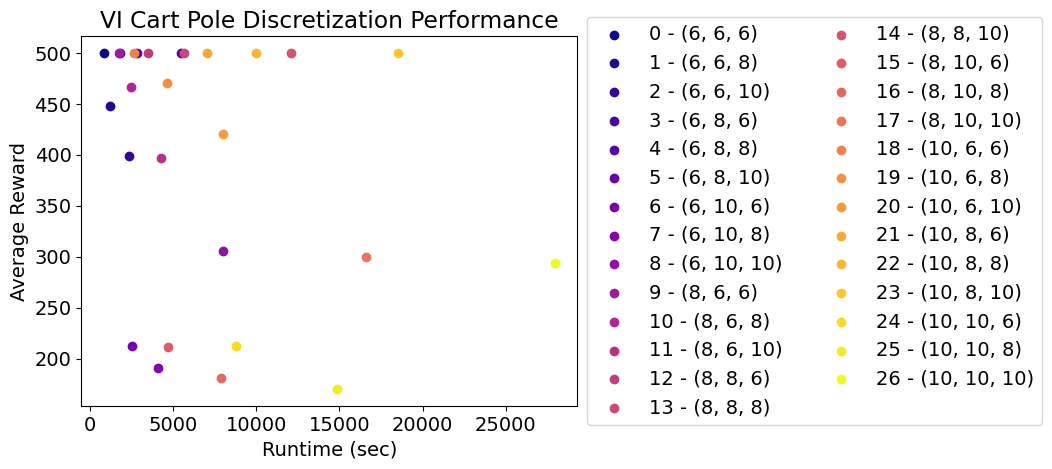

BEST TIME
params
(6, 6, 6, 0.1, 0.1, 0.1)
score
500.0
runtime
854.0818176269531

BEST SCORE
params
(6, 6, 6, 0.1, 0.1, 0.1)
score
500.0
runtime
854.0818176269531


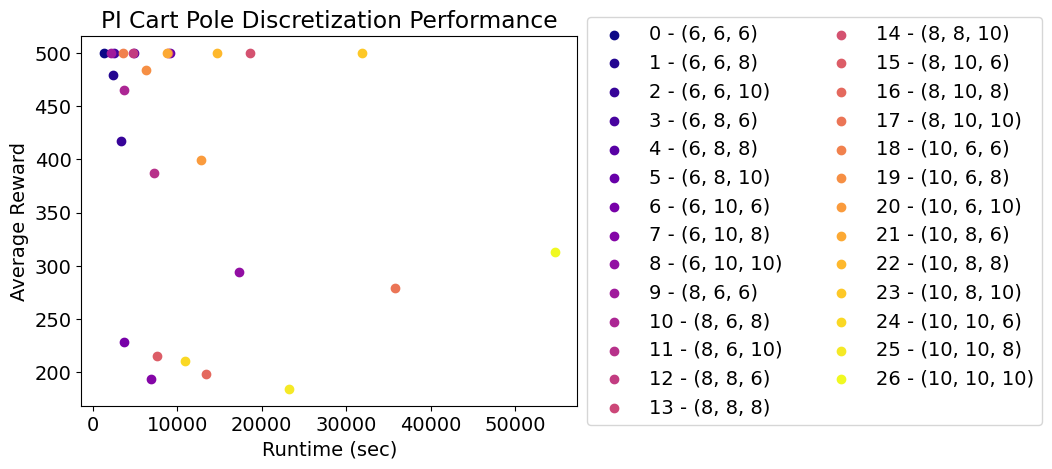

BEST TIME
params
(6, 6, 6, 0.1, 0.1, 0.1)
score
500.0
runtime
1328.549057006836

BEST SCORE
params
(6, 6, 6, 0.1, 0.1, 0.1)
score
500.0
runtime
1328.549057006836


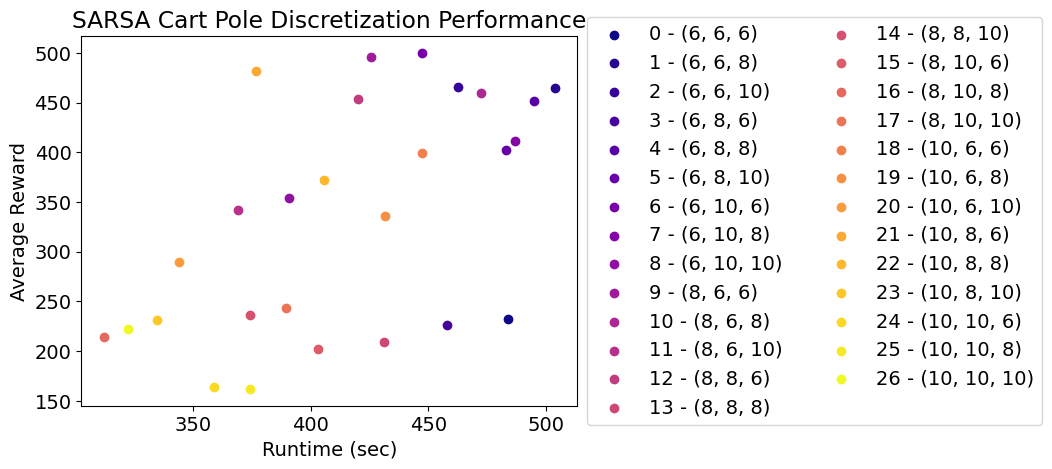

BEST TIME
params
(8, 10, 8, 0.1, 0.1, 0.1)
score
213.8
runtime
312.3469035625458

BEST SCORE
params
(6, 10, 6, 0.1, 0.1, 0.1)
score
500.0
runtime
447.09656167030334


In [66]:
if not os.path.exists('./logs/'):
    os.mkdir('./logs')

# cartpole gym environemnt
cartpole_env = gym.make('CartPole-v1')

param_grid = {
    'position_bins': [6,8,10],
    'velocity_bins': [6,8,10],
    'angular_velocity_bins': [6,8,10],
    'threshold_bins': [0.1],
    'angular_center_resolution': [0.1],
    'angular_outer_resolution': [0.1]
}
params = list(itertools.product(*[param_grid[key] for key in param_grid.keys()]))
for i, (pb, vb, avb, tb, acr, aor) in tqdm(enumerate(params), total=len(params)):
    if not all([os.path.exists(f'./logs/{algo}_{i}.json') for algo in ['VI', 'PI', 'SARSA']]):
        cartpole_env.reset()
        cartpole_tmp = RL_custom(cartpole_wrapper.CartpoleWrapper(
            cartpole_env,
            position_bins=pb,
            velocity_bins=vb,
            angular_velocity_bins=avb, 
            threshold_bins=tb,
            angular_center_resolution=acr,
            angular_outer_resolution=aor
        ))
    if not os.path.exists(f'./logs/VI_{i}.json'):
        cartpole_tmp.env.reset()
        VI = Planner_custom(cartpole_tmp.env.P).value_iteration(gamma=0.99)
        scores = TestEnv().test_env(cartpole_tmp.env, pi=VI['pi'], n_iters=15)
        times = VI['times']
        del VI
        save_experiment_results(f'VI_{i}', 'VI', i, times, scores, pb, vb, avb, tb, acr, aor)
    if not os.path.exists(f'./logs/PI_{i}.json'):
        cartpole_tmp.env.reset()
        PI = Planner_custom(cartpole_tmp.env.P).policy_iteration(gamma=0.99)
        scores = TestEnv().test_env(cartpole_tmp.env, pi=PI['pi'], n_iters=15)
        times = PI['times']
        del PI
        save_experiment_results(f'PI_{i}', 'PI', i, times, scores, pb, vb, avb, tb, acr, aor)
    if not os.path.exists(f'./logs/SARSA_{i}.json'):
        cartpole_tmp.env.reset()
        SARSA = cartpole_tmp.sarsa()
        scores = TestEnv().test_env(cartpole_tmp.env, pi=SARSA['pi'], n_iters=15)
        times = SARSA['times']
        del SARSA
        save_experiment_results(f'SARSA_{i}', 'SARSA', i, times, scores, pb, vb, avb, tb, acr, aor)

colors = plt.colormaps['plasma']
colors27 = colors.resampled(27)

for algo in ['VI', 'PI', 'SARSA']:
    avg_scores = []
    sum_times = []
    for i, p in enumerate(params):
        with open(f'./logs/{algo}_{i}.json', 'r') as file:
            results = json.load(file)
        avg_scores.append(np.mean(results['scores']))
        sum_times.append(np.sum(results['times']))
        plt.scatter([sum_times[-1]], [avg_scores[-1]], label=f'{i} - {str(p[:3])}', c=[colors27.__dict__['colors'][i]])
    plt.title(f'{algo} Cart Pole Discretization Performance')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    plt.xlabel('Runtime (sec)')
    plt.ylabel('Average Reward')
    plt.show()
    best_time_idx = np.argmin(sum_times)
    best_score_idx = np.argmax(avg_scores)
    print('BEST TIME')
    print('params')
    print(params[best_time_idx])
    print('score')
    print(avg_scores[best_time_idx])
    print('runtime')
    print(sum_times[best_time_idx])
    print()
    print('BEST SCORE')
    print('params')
    print(params[best_score_idx])
    print('score')
    print(avg_scores[best_score_idx])
    print('runtime')
    print(sum_times[best_score_idx])

## 4.4 - DQN

source: https://github.com/SeeknnDestroy/DQN-CartPole